## ModelDB usecase: Logging and Querying Model Metadata
This example features:

* Tensorflow's Keras API for building neural networks
* verta's Python client logging observations and artifacts during validation
* verta's Python client retrieving the loss/accuracy plot and the trained model from the validation process

Follow the steps in this [repo](https://github.com/VertaAI/modeldb) to setup the environment.

### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time
import six
from sklearn import datasets

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from verta import Client
client = Client("http://localhost:3000")

connection successfully established


#### Start - Project, Experiment, Experiment Run

In [3]:
proj = client.set_project("Digit Classification")
expt = client.set_experiment("Neural Network Model")
run = client.set_experiment_run("Second Run")

set existing Project: Digit Classification from personal workspace
set existing Experiment: Neural Network Model
set existing ExperimentRun: Second Run


### Data Science Model Development
#### Import Data

In [4]:
data = datasets.load_digits()
X = data['data']
y = data['target']

In [5]:
df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                  columns=["pixel_{}".format(i) for i in range(X.shape[-1])] + ['digit'])

df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,digit
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0


<Figure size 432x288 with 0 Axes>

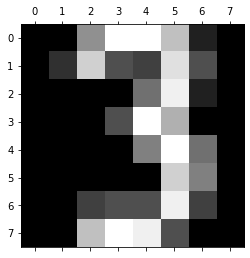

In [6]:
plt.gray()
plt.matshow(data.images[1300])
plt.show()

In [7]:
# log data
run.log_dataset("train_data", df, overwrite=True) # overwrite if artifact already exist

upload complete (train_data.pkl)


#### Hyperparameters

In [ ]:
hyperparams = {
    'hidden_size': 256,
    'dropout': 0.2,
    'batch_size': 1024,
    'num_epochs': 10,
    'optimizer': "adam",
    'loss': "sparse_categorical_crossentropy",
    'validation_split': 0.1,
}
# log the hyperparameters
run.log_hyperparameters(hyperparams)
# if these hyperparams already exist, you will get an error, there is no overwrite option

#### NN Model

In [9]:
model = keras.models.Sequential()
#model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(hyperparams['hidden_size'], activation=tf.nn.relu, input_shape=(X.shape[1],)))
model.add(keras.layers.Dropout(rate=hyperparams['dropout']))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer=hyperparams['optimizer'],
              loss=hyperparams['loss'],
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 19,210
Trainable params: 19,210
Non-trainable params: 0
_________________________________________________________________


In [10]:
def log_validation_callback(epoch, logs):  # Keras will call this each epoch
    run.log_observation("train_loss", float(logs['loss']))
    run.log_observation("train_acc", float(logs['accuracy']))
    run.log_observation("val_loss", float(logs['val_loss']))
    run.log_observation("val_acc", float(logs['val_accuracy']))
    
model.fit(X, y,
          validation_split=hyperparams['validation_split'],
          batch_size=hyperparams['batch_size'], epochs=hyperparams['num_epochs'],
         callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=log_validation_callback)])

Train on 1617 samples, validate on 180 samples
Epoch 1/10
1617/1617 [==============================] - 0s 233us/sample - loss: 8.2164 - accuracy: 0.0736 - val_loss: 5.3569 - val_accuracy: 0.0500
Epoch 2/10
1617/1617 [==============================] - 0s 148us/sample - loss: 5.8314 - accuracy: 0.0934 - val_loss: 3.8400 - val_accuracy: 0.1000
Epoch 3/10
1617/1617 [==============================] - 0s 105us/sample - loss: 4.5739 - accuracy: 0.1515 - val_loss: 2.8582 - val_accuracy: 0.2278
Epoch 4/10
1617/1617 [==============================] - 0s 221us/sample - loss: 3.5685 - accuracy: 0.2208 - val_loss: 2.3653 - val_accuracy: 0.3778
Epoch 5/10
1617/1617 [==============================] - 0s 252us/sample - loss: 3.0359 - accuracy: 0.3302 - val_loss: 1.9466 - val_accuracy: 0.4500
Epoch 6/10
1617/1617 [==============================] - 0s 174us/sample - loss: 2.4362 - accuracy: 0.4230 - val_loss: 1.4624 - val_accuracy: 0.5167
Epoch 7/10
1617/1617 [==============================] - 0s 95us/s

In [11]:
# log model
run.log_model(model)

upload complete (custom_modules.zip)
upload complete (model.pkl.hdf5)
upload complete (model_api.json)


#### Create and Store Plot of Training Observations

upload complete (validation_plot.png)


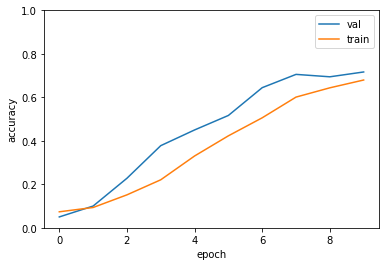

In [12]:
plt.plot([obs[0] for obs in run.get_observation("val_acc")], label="val")
plt.plot([obs[0] for obs in run.get_observation("train_acc")], label="train")
plt.ylim(0, 1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
run.log_image("validation_plot", plt)
plt.show()

### Revisit Workflow

#### Accuracy plot

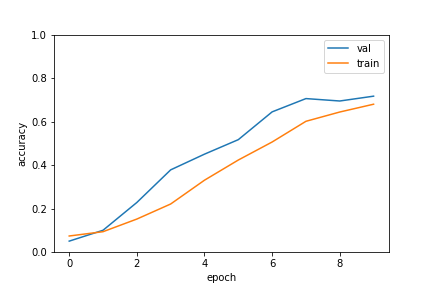

In [13]:
run.get_image("validation_plot")

#### Retrieve model

In [14]:
model = run.get_model()

#### Calculate and Log Accuracy on Full Training Set

In [15]:
train_loss, train_acc = model.evaluate(X, y)
run.log_metric("train_loss", train_loss)
run.log_metric("train_acc", train_acc)

1797/1797 [==============================] - 0s 43us/sample - loss: 0.4762 - accuracy: 0.8347
